# Exploring and preprocessing data #

## I - Import các thư viện cần thiết và load dữ liệu vào pandas dataframe ##

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
# Load dữ liệu vào pandas dataframe
data = pd.read_csv('Data/FPL_tweets.csv', delimiter=',')

## II - Dữ liệu có bao nhiêu dòng và cột ##

In [3]:
number_rows, number_cols = data.shape

print(f'Dữ liệu có số dòng là: {number_rows}')
print(f'Dữ liệu có số cột là: {number_cols}')

Dữ liệu có số dòng là: 114466
Dữ liệu có số cột là: 13


## III - Khám phá dòng của dữ liệu ##

### 1. Ý nghĩa của mỗi dòng ###

In [4]:
# In ra 3 dòng bất kỳ trong tập dữ liệu
data.sample(3)

,ID,Timestamp,User,Text,Hashtag,Retweets,Likes,Replies,Source,Location,Verified_Account,Followers,Following
89258,1.304890e+18,2020-09-12 21:10:33+00:00,leemupy,"@GaryLineker @BBCSport @BBCMOTD Hello, For the...",NaN,0,0,0,"<a href=""http://twitter.com/download/android"" ...","Mashonaland West, Zimbabwe",False,3583,3342
20460,5.477350e+17,2014-12-24 12:45:41+00:00,davidhosey,"144,000 out of 3.3million! I scored 77 points ...",NaN,0,0,0,"<a href=""https://dev.twitter.com/docs/tfw"" rel...","Toronto, ON & Sarasota, FL",False,151,232
107618,1.556650e+18,2022-08-08 14:27:21+00:00,Melchis58253672,@ama_etwepa1 @abenakorkorr It's Fantasy Premie...,NaN,0,1,1,"<a href=""http://twitter.com/download/android"" ...","Accra, Ghana",False,58,249


Mỗi dòng trong bảng mô tả một tweet riêng biệt, bao gồm thông tin về người đăng, nội dung tweet, tương tác và các chi tiết khác.



### 2. Có tồn tại các dòng trùng lắp không? ###

In [5]:
data[data.duplicated()]

,ID,Timestamp,User,Text,Hashtag,Retweets,Likes,Replies,Source,Location,Verified_Account,Followers,Following


Dữ liệu trên không có dòng nào là trùng nhau.

## IV - Khám phá cột của dữ liệu ##

### 1. Ý nghĩa của mỗi cột ###

| Tên cột  | Ý nghĩa  |
|---|---|
| ID  | Mã định danh độc nhất cho mỗi tweet  |
| Timestamp  | Ngày giờ tweet được đăng tải  |
| User  | Tên tài khoản đăng tải tweet  |
| Text  | Nội dung của tweet  |
| Hashtag  | Hashtag của tweet (nếu có)  |
| Retweets  | Số lần tweet được retweet  |
| Likes  | Lượt like của tweet |
| Replies  | Lượt phản hồi của tweet  |
| Source  | Nguồn hoặc thiết bị đăng tải tweet  |
| Location  | Địa điểm được đề cập ở hồ sơ của tài khoản đăng tải tweet (nếu có)  |
| Verified_Account  | Trạng thái xác minh của tài khoản (TRUE hoặc FALSE)   |
| Followers  | Số lượng tài khoản theo dõi của tài khoản đăng tải tweet  |
| Following  | Số lượng tài khoản mà tài khoản đăng tải tweet theo dõi |

*Thông tin của dữ liệu (likes, replies....) được ghi nhận tại thời điểm thu thập dữ liệu và có thể thay đổi ở thời điểm hiện tại.*

### 2. Kiểu dữ liệu của mỗi cột ###

In [6]:
data.dtypes

ID                  float64
Timestamp            object
User                 object
Text                 object
Hashtag              object
Retweets              int64
Likes                 int64
Replies               int64
Source               object
Location             object
Verified_Account       bool
Followers             int64
Following             int64
dtype: object

Để có thể hiểu được rõ hơn về các cột có kiểu dữ liệu object, quá trình phân tách kiểu dữ liệu object sẽ được áp dụng.

In [7]:
def open_object_dtype(s):
    dtypes = set()
    dtypes.update(s.apply(type))
    return dtypes

data[data.dtypes.index[data.dtypes == object]].apply(open_object_dtype)

Timestamp                     {<class 'str'>}
User                          {<class 'str'>}
Text                          {<class 'str'>}
Hashtag      {<class 'float'>, <class 'str'>}
Source                        {<class 'str'>}
Location     {<class 'float'>, <class 'str'>}
dtype: object

Để tập dữ liệu được phù hợp, những cột dữ liệu sau cần chuyển kiểu dữ liệu:
* ID: kiểu string
* Timestamp: kiểu datetime
* Hashtag: kiểu python list (nếu có hashtag)
* Location: dữ liệu ở cột location không được chuẩn hóa (người dùng có thể điền bất kỳ thông tin gì ở cột này) và không thực sự hữu ích nên dữ liệu ở cột này sẽ được giữ nguyên. Có thể in ra mười dòng ngẫu nhiên để thấy rõ hơn điều này.

### 3. Tiền xử lý - chuyển kiểu dữ liệu ###

In [8]:
# Cột ID
data['ID'] = data['ID'].astype(str)

# Cột timestamp
data['Timestamp'] = pd.to_datetime(data['Timestamp'], utc=True)

# Cột hashtag
def hashtag_pre(s):
    '''
    Tiền xử lý dữ liệu ở cột Hashtag (dữ liệu ở biến s):
    1. Loại bỏ các ký tự []''
    2. Chuyển các phần tử được phân cách bởi dấu phẩy vào list.

    Ví dụ thực thi:
    >>> test = hashtag_pre("['FPL', 'FPLCommunity']")
    >>> test, type(test), len(test)
    (['FPL', ' FPLCommunity'], list, 2)
    
    '''
    if type(s) != float:
        # Chuyển kiểu dữ liệu sang string
        result = str(s)
        
        # Loại bỏ ký tự
        chars = "[]'' "
        for char in chars:
            result = result.replace(char, '')

        # Chuyển các ký tự thành chữ thường
        result = result.lower()
        
        # Lưu trữ kết quả vào list
        result = list(result.split(','))
        
        return result
    else:
        return s

data['Hashtag'] = data['Hashtag'].apply(hashtag_pre)

Sau khi thực thi, kiểu dữ liệu của mỗi cột được in ra như sau:

In [9]:
data.apply(open_object_dtype)

ID                                                    {<class 'str'>}
Timestamp           {<class 'pandas._libs.tslibs.timestamps.Timest...
User                                                  {<class 'str'>}
Text                                                  {<class 'str'>}
Hashtag                             {<class 'float'>, <class 'list'>}
Retweets                                              {<class 'int'>}
Likes                                                 {<class 'int'>}
Replies                                               {<class 'int'>}
Source                                                {<class 'str'>}
Location                             {<class 'float'>, <class 'str'>}
Verified_Account                                     {<class 'bool'>}
Followers                                             {<class 'int'>}
Following                                             {<class 'int'>}
dtype: object

### 4. Sự phân bố của các cột có kiểu dữ liệu số (numerical) ###

Sử dụng một dataframe để tổng hợp các giá trị bao gồm tỉ lệ missing value, min, Q1(25%), median, Q3(75%) và max của các cột dữ liệu:
* Timestamp (mặc dù kiểu dữ liệu là datetime nhưng có thể xem là numerical vì có thể tính min, Q1(25%), median, Q3(75%) và max được)
* Retweets
* Likes
* Replies
* Followers
* Following

In [10]:
numerical_cols = ['Timestamp', 'Retweets', 'Likes', 'Replies', 'Followers', 'Following']

# Tỉ lệ missing value (%)
missing_value = np.sum(np.isnan(data[numerical_cols]), axis=0) / data.shape[0] * 100

# min, Q1(25%), median, Q3(75%) và max
percentile = np.array(np.percentile(data[numerical_cols], [0, 25, 50, 75, 100], axis=0))

# dataframe phân bố
numerical_cols_dist_df = pd.DataFrame( data=[list(missing_value), percentile[0], percentile[1], percentile[2], percentile[3], percentile[4]],
                                       index=['Missing percentage', 'Min', 'Q1(25%)', 'Median', 'Q3(75%)', 'Max'],
                                       columns=numerical_cols)
numerical_cols_dist_df

,Timestamp,Retweets,Likes,Replies,Followers,Following
Missing percentage,0.0,0.0,0.0,0.0,0.0,0.0
Min,2012-10-29 00:03:32+00:00,0.0,0.0,0.0,0.0,0.0
Q1(25%),2014-12-06 15:19:16.750000+00:00,0.0,0.0,0.0,207.0,174.0
Median,2017-11-28 18:41:33.500000+00:00,0.0,0.0,0.0,667.0,499.0
Q3(75%),2020-10-27 14:26:44+00:00,0.0,1.0,0.0,2741.0,1261.0
Max,2023-04-08 23:10:30+00:00,7805.0,85997.0,1317.0,40007982.0,235775.0


#### Nhận xét về sự phân bố dữ liệu

* Giá trị missing value ở các cột dữ liệu đều bằng 0 vì các cột này thể hiện các giá trị đếm (lượt tweet, lượt like...) và có giá trị thấp nhất là 0. Missing value chỉ xảy ra với trường hợp dữ liệu là NaN.
* Ba cột dữ liệu ``Retweets``, ``Likes`` và ``Replies`` thể hiện sự tương tác đối với các tweet. Các cột có giá trị min và Q3 gần như là bằng nhau và bằng 0 ở mỗi cột. Để hiểu rõ hơn về sự phân bố dữ liệu ở ba cột này, chúng ta sẽ sắp xếp dữ liệu tăng dần và trực quan với biểu đồ đường.

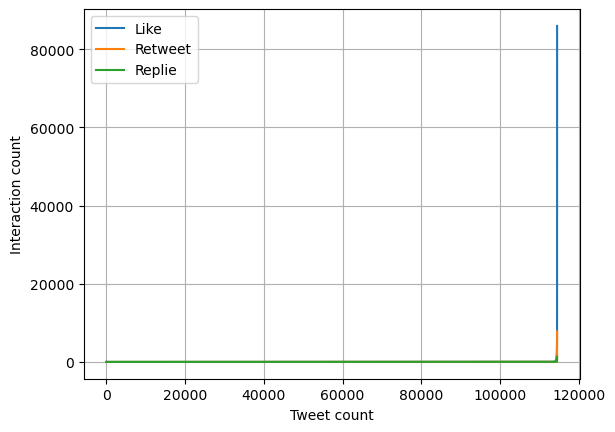

In [11]:
x = np.arange(0, data.shape[0])
plt.plot(x, data['Likes'].sort_values(ascending=True), label = "Like") 
plt.plot(x, data['Retweets'].sort_values(ascending=True), label = 'Retweet')
plt.plot(x, data['Replies'].sort_values(ascending=True), label = 'Replie')
plt.xlabel("Tweet count")
plt.ylabel("Interaction count")

plt.grid()
plt.legend()

* Dựa vào biểu đồ ở trên, chúng ta có thể thấy rằng người dùng có xu hướng sử dụng tương tác like (có thể vì đây là phương thức tương tác dễ thực hiện nhất) và có xu hướng hạn chế bình luận.
* Đa số các tweet được tạo ra nhưng không có sự tương tác và số lần tương tác tập trung ở một vài tweet nhất định. Một giả thiết cho hiện tượng này là các sự kiện mà nhà phát hành tổ chức cho trò chơi Fantasy Premier League. Các sự kiện yêu cầu sự tương tác của người chơi (like, chia sẻ sự kiện thông qua tweet, bình luận, sử dụng hashtag) để có thể nhận được vật phẩm từ sự kiện.
* Những tương tác tập trung chủ yếu ở các tweet của nhà phát hành (các trang chính thức). Những tweet chia sẻ sự kiện là những tweet không có tính mới mẻ và lặp đi lặp lại nên khó có thể thu hút các người dùng khác.

### 5. Sự phân bố của các cột có kiểu dữ liệu phân loại (categorical) ###

Trước hết, chúng em sẽ kiểm tra xem mỗi cột dữ liệu có kiểu phân loại (categorical) có bị thiếu dữ liệu hay không. Các cột dữ liệu có kiểu phân loại (categorical) bao gồm: 
- ``ID``
- ``User``
- ``Text``
- ``Hashtag``
- ``Source``
- ``Location``
- ``Verified_Account``

In [12]:
# Kiểm tra xem  mỗi cột dữ liệu có kiểu phân loại (categorical) có bị thiếu dữ liệu hay không
categorical_cols_lst = ['ID', 'User', 'Text', 'Hashtag', 'Source', 'Location', 'Verified_Account']
percentage_missing_values = np.sum(data[categorical_cols_lst].isna(), axis=0) * 100 / data.shape[0]
pd.DataFrame({"Missing value": percentage_missing_values})

,Missing value
ID,0.000000
User,0.000000
Text,0.000000
Hashtag,74.861531
Source,0.000000
Location,29.488232
Verified_Account,0.000000


Như vậy, chỉ có cột ``Location`` bị thiếu dữ liệu, còn lại thì không.

**Tiền xử lý - với cột ``Source``** \
Chúng em sẽ loại bỏ tag a trong HTML và chỉ lấy tiêu đề.

In [13]:
data['Source'] = data['Source'].str.replace('<.*?>', '', regex=True)
data['Source'].sample(5)

47270                     dlvr.it
40378                     dlvr.it
112170                  TweetDeck
9423      Twitter for BlackBerry®
83450                     dlvr.it
Name: Source, dtype: object

Với mỗi cột dữ liệu có kiểu ``categorical``, chúng em sẽ tính toán các giá trị sau và lưu kết quả vào 1 DataFrame (tất cả các giá trị đều không tính nan):
* Số lượng các giá trị riêng biệt.
* Liệt kê những giá trị riêng biệt.
* Số lượng của từng giá trị riêng biệt và giá trị có số lượng lớn nhất.

In [14]:
categorical_df = data[categorical_cols_lst]
categorical_val_df = pd.DataFrame(index=['num_diff_vals', 'diff_vals_info', 'distribution'], columns=categorical_cols_lst)
categorical_val_df.loc['num_diff_vals'] = [categorical_df[categorical_cols_lst[0]].nunique(), 
                                           categorical_df[categorical_cols_lst[1]].nunique(),
                                           categorical_df[categorical_cols_lst[2]].nunique(),
                                           categorical_df[categorical_cols_lst[3]].explode().nunique(), 
                                           categorical_df[categorical_cols_lst[4]].nunique(),
                                           categorical_df[categorical_cols_lst[5]].dropna().nunique(), # Do cột Location bị thiếu data
                                           categorical_df[categorical_cols_lst[6]].nunique()
                                          ]
categorical_val_df.loc['diff_vals_info'] = [categorical_df[categorical_cols_lst[0]].unique(), 
                                            categorical_df[categorical_cols_lst[1]].unique(),
                                            categorical_df[categorical_cols_lst[2]].unique(),
                                            categorical_df[categorical_cols_lst[3]].explode().unique(), 
                                            categorical_df[categorical_cols_lst[4]].unique(),
                                            categorical_df[categorical_cols_lst[5]].dropna().unique(), # Do cột Location bị thiếu data
                                            categorical_df[categorical_cols_lst[6]].unique()
                                          ]

categorical_val_df.loc['distribution'] = [categorical_df[categorical_cols_lst[0]].value_counts().to_dict(), 
                                           categorical_df[categorical_cols_lst[1]].value_counts().to_dict(),
                                           categorical_df[categorical_cols_lst[2]].value_counts().to_dict(),
                                           categorical_df[categorical_cols_lst[3]].explode().value_counts().to_dict(), 
                                           categorical_df[categorical_cols_lst[4]].value_counts().to_dict(),
                                           categorical_df[categorical_cols_lst[5]].dropna().value_counts().to_dict(), # Do cột Location bị thiếu data
                                           categorical_df[categorical_cols_lst[6]].value_counts().to_dict()
                                          ]

categorical_val_df.loc['max_occurences'] = [data[categorical_cols_lst[0]].mode().values, 
                                           data[categorical_cols_lst[1]].mode().values,
                                           data[categorical_cols_lst[2]].mode().values,
                                           data[categorical_cols_lst[3]].explode().mode().values, 
                                           data[categorical_cols_lst[4]].mode().values,
                                           data[categorical_cols_lst[5]].mode().values, # Do cột Location bị thiếu data
                                           data[categorical_cols_lst[6]].mode().values
                                          ]

categorical_val_df

,ID,User,Text,Hashtag,Source,Location,Verified_Account
num_diff_vals,58623,54030,112217,8599,1158,17685,2
diff_vals_info,"[2.85535e+17, 2.85529e+17, 2.85527e+17, 2.8552...","[AmythLFC, BenBoutwood, ddreid88, ahmedkungora...",[I scored 75 points in Gameweek 20 on Fantasy ...,"[nan, fpl, aiminghigh, winnar, suarez, lambert...","[Twitter for Websites, Twitter Web Client, Twi...","[Essex, Glasgow, Scotland, killamarsh,Sheffiel...","[False, True]"
distribution,"{'1.30472e+18': 134, '1.56356e+18': 113, '1.42...","{'90min_plus3': 938, 'fplcloud': 630, 'Footbal...",{'Join our Fantasy Premier League - The 606v2 ...,"{'fpl': 11951, 'fantasypremierleague': 2656, '...","{'Twitter for Android': 21296, 'Twitter for iP...","{'London, England': 2113, 'United Kingdom': 18...","{False: 109919, True: 4547}"
max_occurences,[1.30472e+18],[90min_plus3],[Join our Fantasy Premier League - The 606v2 F...,[fpl],[Twitter for Android],"[London, England]",[False]


Từ đây, chúng em thấy rằng:
- Mỗi cột có kiểu dữ liệu categorical đều có dữ liệu trùng lắp.
- Với cột ``Source``, đa số các tweets được đăng từ thiết bị của hệ điều hành Android (Twitter for Android).
- Với hai cột ``Text`` và ``Location`` là có một vài dòng chứa biểu tượng emoji. Riêng cột ``Location`` có một vài dòng không phải là một địa điểm cụ thể.
- Đối với cột ``Verified_Account``, đa số các tweets đều được đăng bởi các tài khoản không được xác minh.

Trực quan hóa dữ liệu đối với cột ``Source`` và ``Verified_Account``

Text(0.5, 1.0, 'Source')

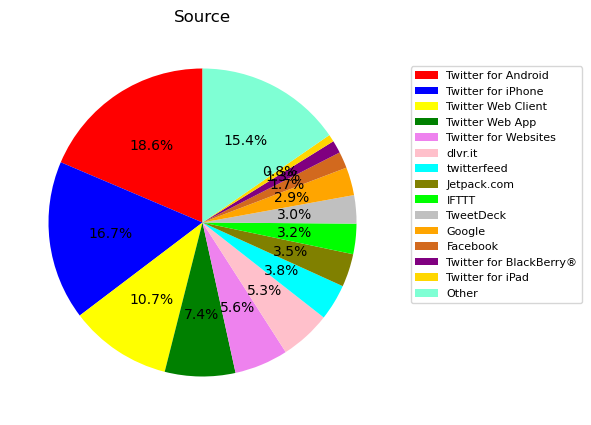

In [15]:
# Trực quan hóa đối với cột Source
num_source_else_vals = np.sum(list(categorical_val_df.loc['distribution']['Source'].values())) - \
np.sum(list(categorical_val_df.loc['distribution']['Source'].values())[0:14])
top_14_max_source_vals = list(categorical_val_df.loc['distribution']['Source'].values())[0:14]
top_14_max_source_vals.append(num_source_else_vals)

top_14_max_source_keys = list(categorical_val_df.loc['distribution']['Source'].keys())[0:14]
top_14_max_source_keys.append('Other')

fig, ax = plt.subplots(figsize=(8,5))
clr_lst = ['red', 'blue', 'yellow', 'green', 'violet', 'pink', 'cyan', 'olive',
          'lime', 'silver', 'orange', 'chocolate', 'purple', 'gold', 'aquamarine']
ax.pie(top_14_max_source_vals, autopct='%.1f%%', startangle=90, colors = clr_lst)
ax.legend(loc='upper right', labels=top_14_max_source_keys, fontsize="8", bbox_to_anchor=(1.0, 0.62, 0.5, 0.3))
ax.set_title('Source')

Text(0.5, 1.0, 'Verified_Account')

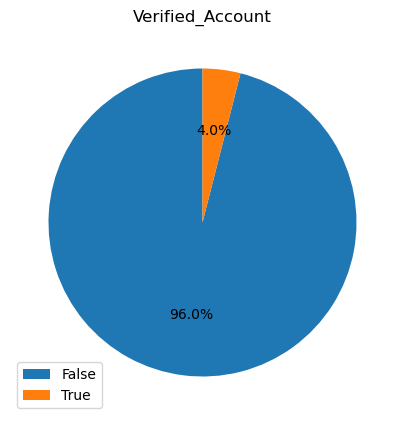

In [16]:
# Trực quan hóa đối với cột Verified_Account
fig, ax = plt.subplots(figsize=(8,5))
distribution_val = categorical_val_df.loc['distribution']

ax.pie(list(distribution_val['Verified_Account'].values()), autopct='%.1f%%', startangle=90)
ax.legend(loc='lower left', labels=list(distribution_val['Verified_Account'].keys()))
ax.set_title('Verified_Account')